<div style="text-align: right"><b> Ana Valentina López Chacón </b></div>
<div style="text-align: right"><b> Reconocimiento de Formas, 2024 - 2025 </b></div>

## **Clasificación de Animales: Fine Tuning con Aumento de datos**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input
keras.utils.set_random_seed(23)


Realizamos la lectura de los datos.

In [2]:
dataset_path = '/kaggle/input/animals10/raw-img'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
num_clases = 10

train_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='training',
    seed=123
)


test_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=True,
    validation_split=0.2,
    subset='validation',
    seed=123
)

validation_split = 0.25  
num_validation_batches = int(validation_split * len(train_dataset)) #.file_paths
validation_dataset = train_dataset.take(num_validation_batches)
train_dataset = train_dataset.skip(num_validation_batches)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [3]:
print(f"Number of batches in train dataset: {len(train_dataset)}")
print(f"Number of batches in validation dataset: {len(validation_dataset)}")

Number of batches in train dataset: 492
Number of batches in validation dataset: 163


### **EfficientNetB0**

In [5]:
M = keras.models.load_model('/kaggle/input/efficient_net_aug/keras/default/1/Proyecto_tfag_EfficientNetB0.keras')
for layer in M.layers[:-20]:
    layer.trainable = True

for layer in M.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
        layer._per_input_updates_enabled = False

opt = keras.optimizers.Adam(learning_rate = 1e-5)
M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])

In [6]:
M.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,710,573 (17.97 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [7]:
filename = 'Proyecto_EfficientNetB0_fine-tuningyaug.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_SparseCategoricalAccuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_SparseCategoricalAccuracy', factor=0.2585, patience=5, min_delta=0.0005, min_lr=1e-5)
early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=5, min_delta=0.0005, mode='max')

H = M.fit(train_dataset, batch_size = 128, epochs = 15, validation_data=validation_dataset, verbose=0,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])

2024-10-16 14:28:06.502647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_SparseCategoricalAccuracy improved from inf to 0.97834, saving model to Proyecto_EfficientNetB0_fine-tuningyaug.keras

Epoch 2: val_SparseCategoricalAccuracy improved from 0.97834 to 0.97757, saving model to Proyecto_EfficientNetB0_fine-tuningyaug.keras

Epoch 3: val_SparseCategoricalAccuracy improved from 0.97757 to 0.97738, saving model to Proyecto_EfficientNetB0_fine-tuningyaug.keras

Epoch 4: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 5: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 6: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 7: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 8: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 9: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 10: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 11: val_SparseCategoricalAccuracy did not improve from 0.97738

Epoch 12: val_SparseCategoricalAccuracy d

In [8]:
score = M.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.08342
Precisión: 97.75%


Realizamos la gráfica para losses, accuracy, matriz de confusión y reporte de clasificación.

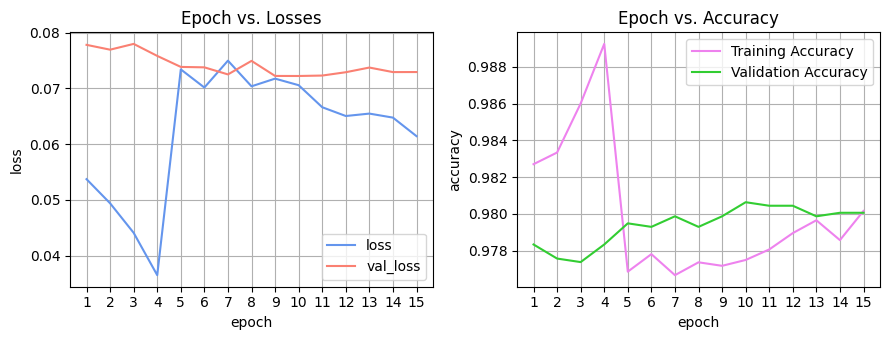

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Epoch vs. Losses")
ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], label = 'loss', color='cornflowerblue')
ax.plot(xx, H.history['val_loss'], label = 'val_loss', color='salmon')
ax.legend()

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title("Epoch vs. Accuracy")
ax.set_xticks(xx)
ax.plot(xx, H.history['SparseCategoricalAccuracy'], label='Training Accuracy', color='violet')
ax.plot(xx, H.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy', color = 'limegreen')
ax.legend()
plt.tight_layout()

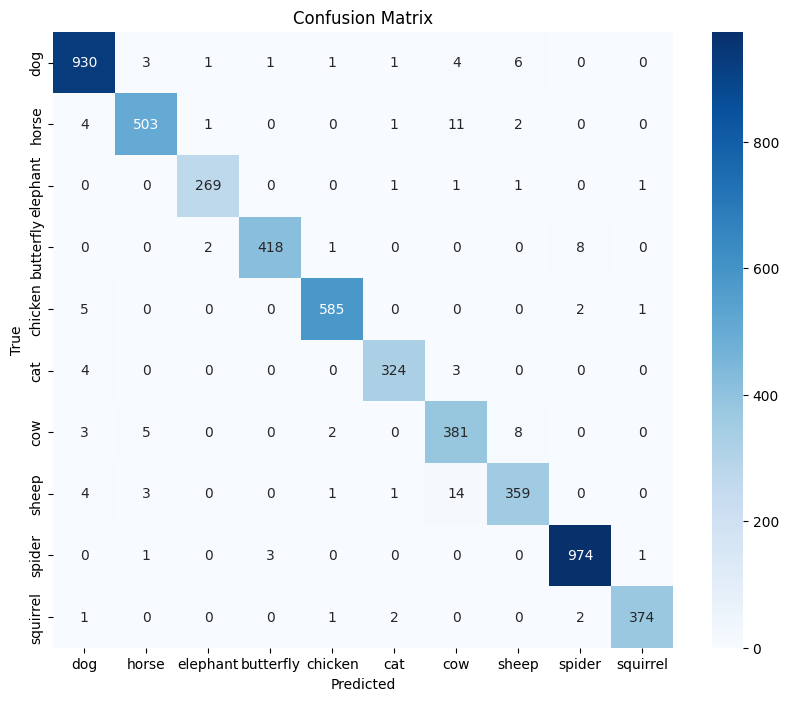

              precision    recall  f1-score   support

         dog       0.98      0.98      0.98       947
       horse       0.98      0.96      0.97       522
    elephant       0.99      0.99      0.99       273
   butterfly       0.99      0.97      0.98       429
     chicken       0.99      0.99      0.99       593
         cat       0.98      0.98      0.98       331
         cow       0.92      0.95      0.94       399
       sheep       0.95      0.94      0.95       382
      spider       0.99      0.99      0.99       979
    squirrel       0.99      0.98      0.99       380

    accuracy                           0.98      5235
   macro avg       0.98      0.97      0.98      5235
weighted avg       0.98      0.98      0.98      5235



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_labels_and_predictions(dataset, model):
    true_labels = []
    predictions = []

    for images, labels in dataset:
        preds = model.predict(images, verbose = 0)
        predicted_classes = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(predicted_classes)

    return np.array(true_labels), np.array(predictions)

true_labels, predicted_labels = get_labels_and_predictions(test_dataset, M)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
              "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
class_names = [translate[i] for i in test_dataset.class_names]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names = class_names))

### **ResNet50V2**

In [11]:
M = keras.models.load_model('/kaggle/input/resnet_aug/keras/default/1/Proyecto_tfag_ResNet50V2.keras')

for layer in M.layers[:-20]:
    layer.trainable = True

for layer in M.layers:
    if isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = False
        layer._per_input_updates_enabled = False

opt = keras.optimizers.Adam(learning_rate = 0.001)
M.compile(loss="SparseCategoricalCrossentropy", optimizer=opt, metrics=["SparseCategoricalAccuracy"])

In [12]:
M.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 224, 224, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,619,018 (93.91 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [13]:
filename = 'Proyecto_ResNet50V2_fine-tuningyaug.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_SparseCategoricalAccuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_SparseCategoricalAccuracy', factor=0.2585, patience=5, min_delta=0.0005, min_lr=1e-5)
early_cb = keras.callbacks.EarlyStopping(monitor='val_SparseCategoricalAccuracy', patience=5, min_delta=0.0005, mode='max')

H = M.fit(train_dataset, batch_size = 128, epochs = 15, validation_data=validation_dataset, verbose=1,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])

Epoch 1/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - SparseCategoricalAccuracy: 0.9569 - loss: 0.1544
Epoch 1: val_SparseCategoricalAccuracy improved from inf to 0.96089, saving model to Proyecto_ResNet50V2_fine-tuningyaug.keras
492/492 ━━━━━━━━━━━━━━━━━━━━ 84s 146ms/step - SparseCategoricalAccuracy: 0.9569 - loss: 0.1545 - val_SparseCategoricalAccuracy: 0.9609 - val_loss: 0.1417 - learning_rate: 0.0010
Epoch 2/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - SparseCategoricalAccuracy: 0.9647 - loss: 0.1111
Epoch 2: val_SparseCategoricalAccuracy improved from 0.96089 to 0.95859, saving model to Proyecto_ResNet50V2_fine-tuningyaug.keras
492/492 ━━━━━━━━━━━━━━━━━━━━ 72s 141ms/step - SparseCategoricalAccuracy: 0.9647 - loss: 0.1111 - val_SparseCategoricalAccuracy: 0.9586 - val_loss: 0.1656 - learning_rate: 0.0010
Epoch 3/15
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - SparseCategoricalAccuracy: 0.9384 - loss: 0.2055
Epoch 3: val_SparseCategoricalAccuracy did not improve from 0.95859
492

In [14]:
score = M.evaluate(test_dataset, verbose=0)
print(f'Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}')

Loss: 0.119
Precisión: 96.89%


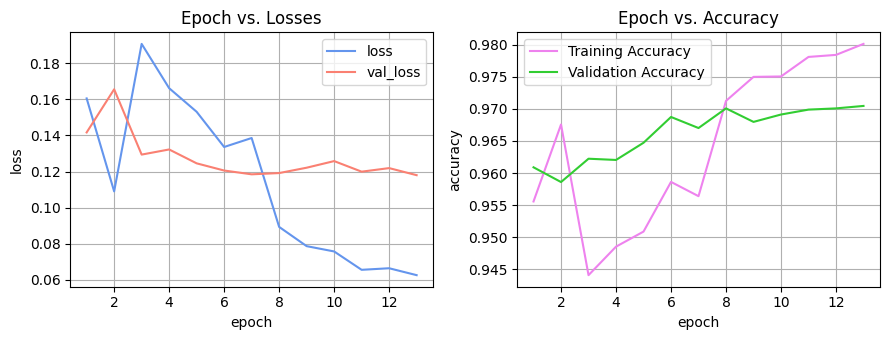

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
xx = np.arange(1, len(H.history['loss'])+1)
ax = axes[0]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title("Epoch vs. Losses")
# ax.set_xticks(xx)
ax.plot(xx, H.history['loss'], label = 'loss', color='cornflowerblue')
ax.plot(xx, H.history['val_loss'], label = 'val_loss', color='salmon')
ax.legend()

ax = axes[1]
ax.grid()
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title("Epoch vs. Accuracy")
# ax.set_xticks(xx)
ax.plot(xx, H.history['SparseCategoricalAccuracy'], label='Training Accuracy', color='violet')
ax.plot(xx, H.history['val_SparseCategoricalAccuracy'], label='Validation Accuracy', color = 'limegreen')
ax.legend()
plt.tight_layout()

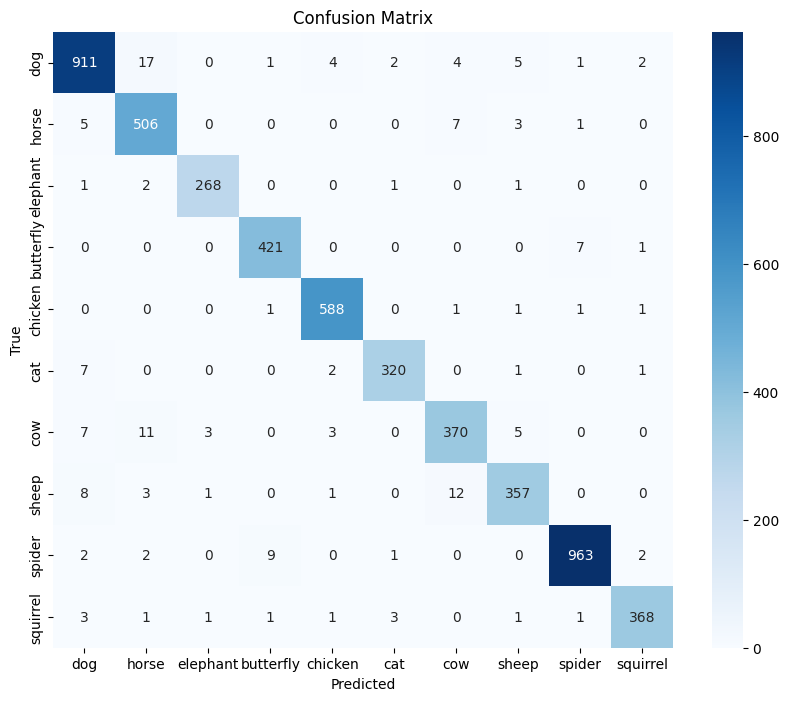

              precision    recall  f1-score   support

         dog       0.97      0.96      0.96       947
       horse       0.93      0.97      0.95       522
    elephant       0.98      0.98      0.98       273
   butterfly       0.97      0.98      0.98       429
     chicken       0.98      0.99      0.99       593
         cat       0.98      0.97      0.97       331
         cow       0.94      0.93      0.93       399
       sheep       0.95      0.93      0.94       382
      spider       0.99      0.98      0.99       979
    squirrel       0.98      0.97      0.97       380

    accuracy                           0.97      5235
   macro avg       0.97      0.97      0.97      5235
weighted avg       0.97      0.97      0.97      5235



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def get_labels_and_predictions(dataset, model):
    true_labels = []
    predictions = []

    for images, labels in dataset:
        preds = model.predict(images, verbose = 0)
        predicted_classes = np.argmax(preds, axis=1)
        true_labels.extend(labels.numpy())
        predictions.extend(predicted_classes)

    return np.array(true_labels), np.array(predictions)

true_labels, predicted_labels = get_labels_and_predictions(test_dataset, M)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken",
              "gatto": "cat", "mucca": "cow", "pecora": "sheep", "ragno": "spider", "scoiattolo": "squirrel"}
class_names = [translate[i] for i in test_dataset.class_names]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names = class_names))

## **Resumen de Resultados**

- Con el MLP sencillo obtenemos una precisión del 36.6%.
- Usando el Keras Tuner para la arquitectura de red obtenemos una precisión del 37.1%.
- Al realizar el ajuste del Learning rate y BatchSize obtenemos una precisión del 37.19%.
- Al incluir ReduceOnPlateau en los callbacks obtenemos una precisión del 41.47%.
- Con capas convolucionales y de pooling la precisión sube a un 67.47%, sin embargo se presenta mucho overfitting.
- Al hacer regularización se obtiene una precisión del 58.47%, con menos overfitting.
- La EfficientNetB0 obtiene una precisión de 97.61%.
- Empleando la ResNet50 se obtiene una precisión del 96.73%.
- Con Fine-tuning la EfficientNetB0 decrece en un 0.04%, sigue teniendo una buena precisión de 97.57%.
- La Resnet50 mejora en un 0.06% con una precisión de 96.79%. 
- Al incluir datos aumentados la EfficientNetB0 obtiene una precisión del 96.5%.
- La ResNet50 con datos aumentados presenta una precisión del 96.89%.

Se puede ver como el accuracy de entrenamiento fluctua en las primeras epocas, debido a que debe re-entrenar las ultimas capas con datos de baja calidad, sin embargo finalmente se estabiliza.

- Al realizar Fine-tuning con los datos aumentados, se obtiene el mejor resultado de precisión de todo el proyecto que sería con la EfficientNetB0 con una precisión del 97.75%.
- Para el modelo ResNet50 el valor de precisión se mantiene en 96.89% sin mebargo sigue siendo superior al los mejores valores de las pruebas anteriores. 